# Tracking memory leaks / memory fragmentation

This notebook is for finding out where fastai doesn't allocate GPU RAM efficiently. Feel free to add other sections. Currently it only does a basic training loop, with some unfreezing and inference.

The detection comes from reading the output of IPyExperimentsPytorch per-cell reports.

In particular watch Delta Peak column which may indicate where more GPU RAM was allocated before freeing some, which may lead to smalish holes in allocated GPU RAM which can't be re-used and thus causing fragmentation and making your gpu card 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
from pathlib import Path
import numpy as np
from ipyexperiments import IPyExperimentsPytorch
#! pip install ipyexperiments

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
assert str(device) == 'cuda:0', f"we want GPU, got {device}"

In [5]:
from IPython.display import Markdown, display
def alert(string, color='red'):
    display(Markdown(f"<span style='color:{color}'>**{string}**</span>"))

In [6]:
# x1 = consume_cpu(2**14) # about 1GB
def consume_gpu(n): return torch.ones((n, n)).cuda()
def consume_1gb(): return [consume_gpu(2**14)]
def consume_6gb(): return [consume_1gb() for x in range(6) ]

def reclaim():
    gc.collect()
    torch.cuda.empty_cache()

In [7]:
import tracemalloc, threading, torch, time, pynvml
from fastai.utils.mem import *
from fastai.vision import *

if not torch.cuda.is_available(): raise Exception("pytorch is required")

def preload_pytorch():
    torch.ones((1, 1)).cuda()
    
def gpu_mem_get_used_no_cache():
    torch.cuda.empty_cache()
    return gpu_mem_get().used

def gpu_mem_used_get_fast(gpu_handle):
    info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
    return int(info.used/2**20)

def torch_mem_report():
    torch.cuda.empty_cache()
    print(list(map(lambda x: int(x/2**20), [torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated(), torch.cuda.memory_cached(), torch.cuda.max_memory_cached()])))
    
preload_pytorch()
pynvml.nvmlInit()

class PeakMemMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder

    def peak_monitor_start(self):
        self.peak_monitoring = True

        # start RAM tracing
        tracemalloc.start()

        # this thread samples RAM usage as long as the current epoch of the fit loop is running
        peak_monitor_thread = threading.Thread(target=self.peak_monitor_func)
        peak_monitor_thread.daemon = True
        peak_monitor_thread.start()
        
    def peak_monitor_stop(self):
        tracemalloc.stop()
        self.peak_monitoring = False
        
    def peak_monitor_func(self):
        self.gpu_mem_used_peak = -1

        gpu_id = torch.cuda.current_device()
        gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_id)

        while True:
            gpu_mem_used = gpu_mem_used_get_fast(gpu_handle)
            self.gpu_mem_used_peak = max(gpu_mem_used, self.gpu_mem_used_peak)
            if not self.peak_monitoring: break
            time.sleep(0.001) # 1msec

    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['cpu used',  'peak', 'gpu used',  'peak'])
                    
    def on_epoch_begin(self, **kwargs):
        self.peak_monitor_start()
        self.gpu_before = gpu_mem_get_used_no_cache()

    def on_epoch_end(self, **kwargs):
        cpu_current, cpu_peak =  list(map(lambda x: int(x/2**20), tracemalloc.get_traced_memory()))
        gpu_current = gpu_mem_get_used_no_cache() - self.gpu_before
        gpu_peak    = self.gpu_mem_used_peak      - self.gpu_before
        self.peak_monitor_stop()
        # The numbers are deltas in MBs (beginning of the epoch and the end)
        self.learn.recorder.add_metrics([cpu_current, cpu_peak, gpu_current, gpu_peak])

# Prep dataset

In [8]:
exp1 = IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 Ti (8119 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2285 13177  31588 MB   7.24% 
GPU:   503  7616   8119 MB   6.19% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0.000s
･ CPU:         0       0     2285 MB |
･ GPU:         0       0      503 MB |


In [9]:
path = untar_data(URLs.MNIST)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.003s
･ CPU:         0       1     2285 MB |
･ GPU:         0       0      503 MB |


In [10]:
# setup
defaults.cmap='binary'
bs=512
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
#arch="resnet34"
arch="resnet50"

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.007s
･ CPU:         0       0     2285 MB |
･ GPU:         0       0      503 MB |


In [11]:
il = ImageItemList.from_folder(path, convert_mode='L')
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.548s
･ CPU:        26       0     2352 MB |
･ GPU:         0       0      503 MB |


In [12]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /home/stas/.fastai/data/mnist_png;

Test: None

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.113s
･ CPU:         8       4     2361 MB |
･ GPU:         0       0      503 MB |


In [13]:
src = sd.label_from_folder()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.201s
･ CPU:         0       0     2361 MB |
･ GPU:         0       0      503 MB |


In [14]:
ll = src.transform(tfms)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.001s
･ CPU:         0       0     2361 MB |
･ GPU:         0       0      503 MB |


4


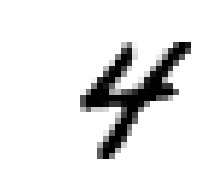

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.284s
･ CPU:         0       1     2364 MB |
･ GPU:         0       0      503 MB |


In [15]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)
x,y = data.train_ds[0]
x.show()
print(y)

# Train and Validate


In [16]:
model = getattr(models, arch) # models.resnet34

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.001s
･ CPU:         0       0     2364 MB |
･ GPU:         0       0      503 MB |


In [17]:
learn = create_cnn(data, model, metrics=[accuracy], callback_fns=PeakMemMetric)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.658s
･ CPU:         0       0     2524 MB |
･ GPU:       106       0      609 MB |


In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 16.697s
･ CPU:         0       0     2534 MB |
･ GPU:        14    6206      623 MB |


In [ ]:
reclaim() # resets lr_find's GPU RAM consumption

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.040s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0      623 MB |


In [ ]:
#learn.recorder.plot()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.025s
･ CPU:         0       0     2534 MB |
･ GPU:         0       0      623 MB |


In [ ]:
learn.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.221688,0.064411,0.978500,0,2,42,3968


･ RAM: △Consumed △Peaked  Used Total | Exec time 18.995s
･ CPU:         0       0     2535 MB |
･ GPU:        26    3942      649 MB |


In [ ]:
# cycle this:
learn.fit_one_cycle(1, max_lr=1e-2)
learn.fit_one_cycle(2, max_lr=1e-2)
learn.save(f'reload1')
_=learn.load(f'reload1')
reclaim() # resets lr_find's GPU RAM consumption

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.079394,0.042086,0.987000,0,2,14,954


epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.076606,0.081787,0.976100,0,2,14,954
2,0.046904,0.025560,0.992000,0,2,6,944


･ RAM: △Consumed △Peaked  Used Total | Exec time 54.411s
･ CPU:         0       0     2536 MB |
･ GPU:         0     958      649 MB |


In [ ]:
reclaim() # resets fit_one_cycle's GPU RAM consumption

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.041s
･ CPU:         0       0     2536 MB |
･ GPU:         0       0      649 MB |


In [ ]:
learn.save(f'reload1')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.234s
･ CPU:         0       0     2536 MB |
･ GPU:         0       0      649 MB |


### Proposed Change
end of `learn.load()` is a place where reclaim should be executed, so that the GPU RAM taken previously by the model is unloaded - otherwise it's doubled in size until gc.collect() arrives some time in the future.

Currently, we get delta peaked reported @ 126MB for models.resnet34, and it should be 0 peaked, if first the model is unloaded and then loaded again.

In [ ]:
_=learn.load(f'reload1')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.096s
･ CPU:         0       0     2536 MB |
･ GPU:         0     126      649 MB |


In [ ]:
cpu_mem, gpu_mem, time_data = exp1.cl.data
if b2mb(gpu_mem.peaked_delta) > 10:
    alert(f"load() caused potential fragmentation by not unloading model first, delta peaked at {b2mb(gpu_mem.peaked_delta)} MB")

<span style='color:red'>**load() caused potential fragmentation by not unloading model first, delta peaked at 126 MB**</span>

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.002s
･ CPU:         0       0     2536 MB |
･ GPU:         0       0      649 MB |


In [ ]:
reclaim() # resets load's GPU RAM consumption

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.065s
･ CPU:         0       0     2536 MB |
･ GPU:         0       0      649 MB |


In [ ]:
#reclaim_tensors()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.026s
･ CPU:         0       0     2536 MB |
･ GPU:         0       0      649 MB |


In [ ]:
learn.lr_find(end_lr=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 12.902s
･ CPU:         0       0     2536 MB |
･ GPU:         0     954      649 MB |


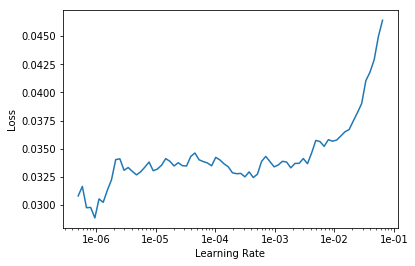

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.368s
･ CPU:         0       2     2536 MB |
･ GPU:         0       0      649 MB |


In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak
1,0.058548,0.029637,0.991100,0,2,4,954


･ RAM: △Consumed △Peaked  Used Total | Exec time 18.034s
･ CPU:         0       0     2537 MB |
･ GPU:         0     954      649 MB |


In [ ]:
learn.save(f'leak2')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.147s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0      649 MB |


## Fine tuning

In [ ]:
_=learn.load(f'leak2')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.097s
･ CPU:         0       0     2537 MB |
･ GPU:         0     126      649 MB |


In [ ]:
learn.unfreeze()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.004s
･ CPU:         0       0     2537 MB |
･ GPU:         0       0      649 MB |


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
･ RAM: △Consumed △Peaked  Used Total | Exec time 12.012s
･ CPU:         0       0     2537 MB |
･ GPU:       226    3486      875 MB |


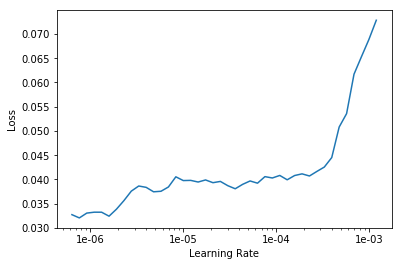

･ RAM: △Consumed △Peaked  Used Total | Exec time 0.299s
･ CPU:         0       1     2537 MB |
･ GPU:         0       0      875 MB |


In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-2
learn.fit_one_cycle(1, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,cpu used,peak,gpu used,peak


In [ ]:
learn.save(f'leak3')

In [ ]:
learn.freeze()

In [ ]:
learn.export()

# Inference via learn.export

In [ ]:
learn = load_learner(path, test=ImageItemList.from_folder(path/'testing'))

In [ ]:
learn.data.test_ds
len(learn.data.test_ds)

In [ ]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
len(predictions[0])

In [ ]:
# get predictions as numpy
pred = predictions[0].numpy()
pred[0]
pred_df = pd.DataFrame(pred)
pred_df[:5]
#pred_df.sort_values(by="preds")

# Inference with manual learn re-construction

In [ ]:
del learn
gc.collect()
#learn.opt.clear()
torch.cuda.empty_cache()

In [ ]:
#del exp1

In [ ]:
bs = 32
tfms = get_transforms(do_flip=False)


In [ ]:
data = (src.add_test_folder(test_folder='testing')
        .transform(tfms) # .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn = create_cnn(data, model)
_=learn.load(f'leak3')


In [ ]:
# learn.data = (src.add_test_folder(test_folder='test')
#         .transform(tfms) # .transform(tfms, size=256)
#         .databunch().normalize(imagenet_stats))

In [ ]:
learn.data.test_ds
len(learn.data.test_ds)

In [ ]:
#learn.validate()

In [ ]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

# need to also try learn.TTA()

In [ ]:
len(predictions[0])

In [ ]:
# get predictions as numpy
pred = predictions[0].numpy()
pred[0]
pred_df = pd.DataFrame(pred)
pred_df[:5]
#pred_df.sort_values(by="preds")